# Setup and Config

In [151]:
import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sns
import anndata as ad
import PyPDF2
import matplotlib.pyplot as plt
import statistics as st
from pathlib import Path
import scipy.stats as stats
from collections import defaultdict



#Adata Files
adata_processed = "/mnt/ibm_sm/home/lea.mcgeever/ms/notebooks/adata_files/adata_processed__02172022.h5ad"
adata = sc.read_h5ad(adata_processed)

adata_tissue = "/mnt/ibm_sm/home/lea.mcgeever/ms/notebooks/adata_files/adata_thymus_processed_02172022.h5ad"
tissue = sc.read_h5ad(adata_tissue)

tissue_sg_path = "/mnt/ibm_sm/home/lea.mcgeever/ms/notebooks/adata_files/tissue_sg1_02172022.h5ad"
tissue_sg1 = sc.read_h5ad(tissue_sg_path)

sc.settings.verbosity = 3             
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.1 scipy==1.6.2 pandas==1.2.4 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.8 pynndescent==0.5.5


In [152]:
from statannot import add_stat_annotation

# Clustering

In [ ]:
adata_thymus = adata[adata.obs['tissue'] == "Thymus"].copy()
sc.pp.pca(adata_thymus)
sc.pp.neighbors(adata_thymus, n_pcs=9)
sc.tl.leiden(adata_thymus) 
sc.tl.umap(adata_thymus)

In [ ]:
#adata_thymus_processed = "/mnt/ibm_sm/home/lea.mcgeever/ms/notebooks/adata_files/adata_thymus_processed_02172022.h5ad"
#adata_thymus.write(adata_thymus_processed)

In [ ]:
sc.pl.pca_overview(tissue, color = 'cell_ontology_class')

# Looking at clustering consistency

In [ ]:
sc.pl.umap(tissue, color = ['leiden', 'free_annotation'])


In [ ]:
#sc.pl.umap(tissue_sg1, color = ['S_score', 'G2M_score'])
#reprocess & cluster tissue_sg1

In [ ]:
sc.pl.umap(tissue, color = ['leiden', 'cell_ontology_class'])


In [ ]:
sc.pl.umap(tissue, color = ['leiden', 'cell_ontology_class'])

In [ ]:
sc.pl.umap(tissue, color = ['leiden', 'cell_ontology_class'])


In [ ]:
sc.pl.umap(tissue, color = ['leiden', 'cell_ontology_class'])

# Characterize cell proportions across ages

In [153]:
tis_cells = list(set(tissue.obs['cell_ontology_class']))
ages = ['3m','18m','24m']

In [154]:
from collections import defaultdict

def cell_per_tissue(celltypelist, adata):
    ''' Input is cell type list. Output is a pandas DataFrame 
    of the percentage of that cell type for inputted subsetted adata tissue object'''
    
    data = defaultdict(list)
    
    for a in ages:
        b = adata[adata.obs['age']== a]#filter by age
        for e in celltypelist:#going through keys/tissue types       
            c = b[b.obs['cell_ontology_class']== e]#have adata filtered by cell types in list
            tissue_cell_count = adata.n_obs
            data["Age"].append(a)
            data["Cell Type"].append(e)
            data["Cell Count"].append(c.n_obs)
            data["Cell Type/Tissue %"].append((c.n_obs/b.n_obs)*100)
            
    df = pd.DataFrame(data)
    return df

[Text(0.5, 1.0, 'Cell Type % of Thymus')]

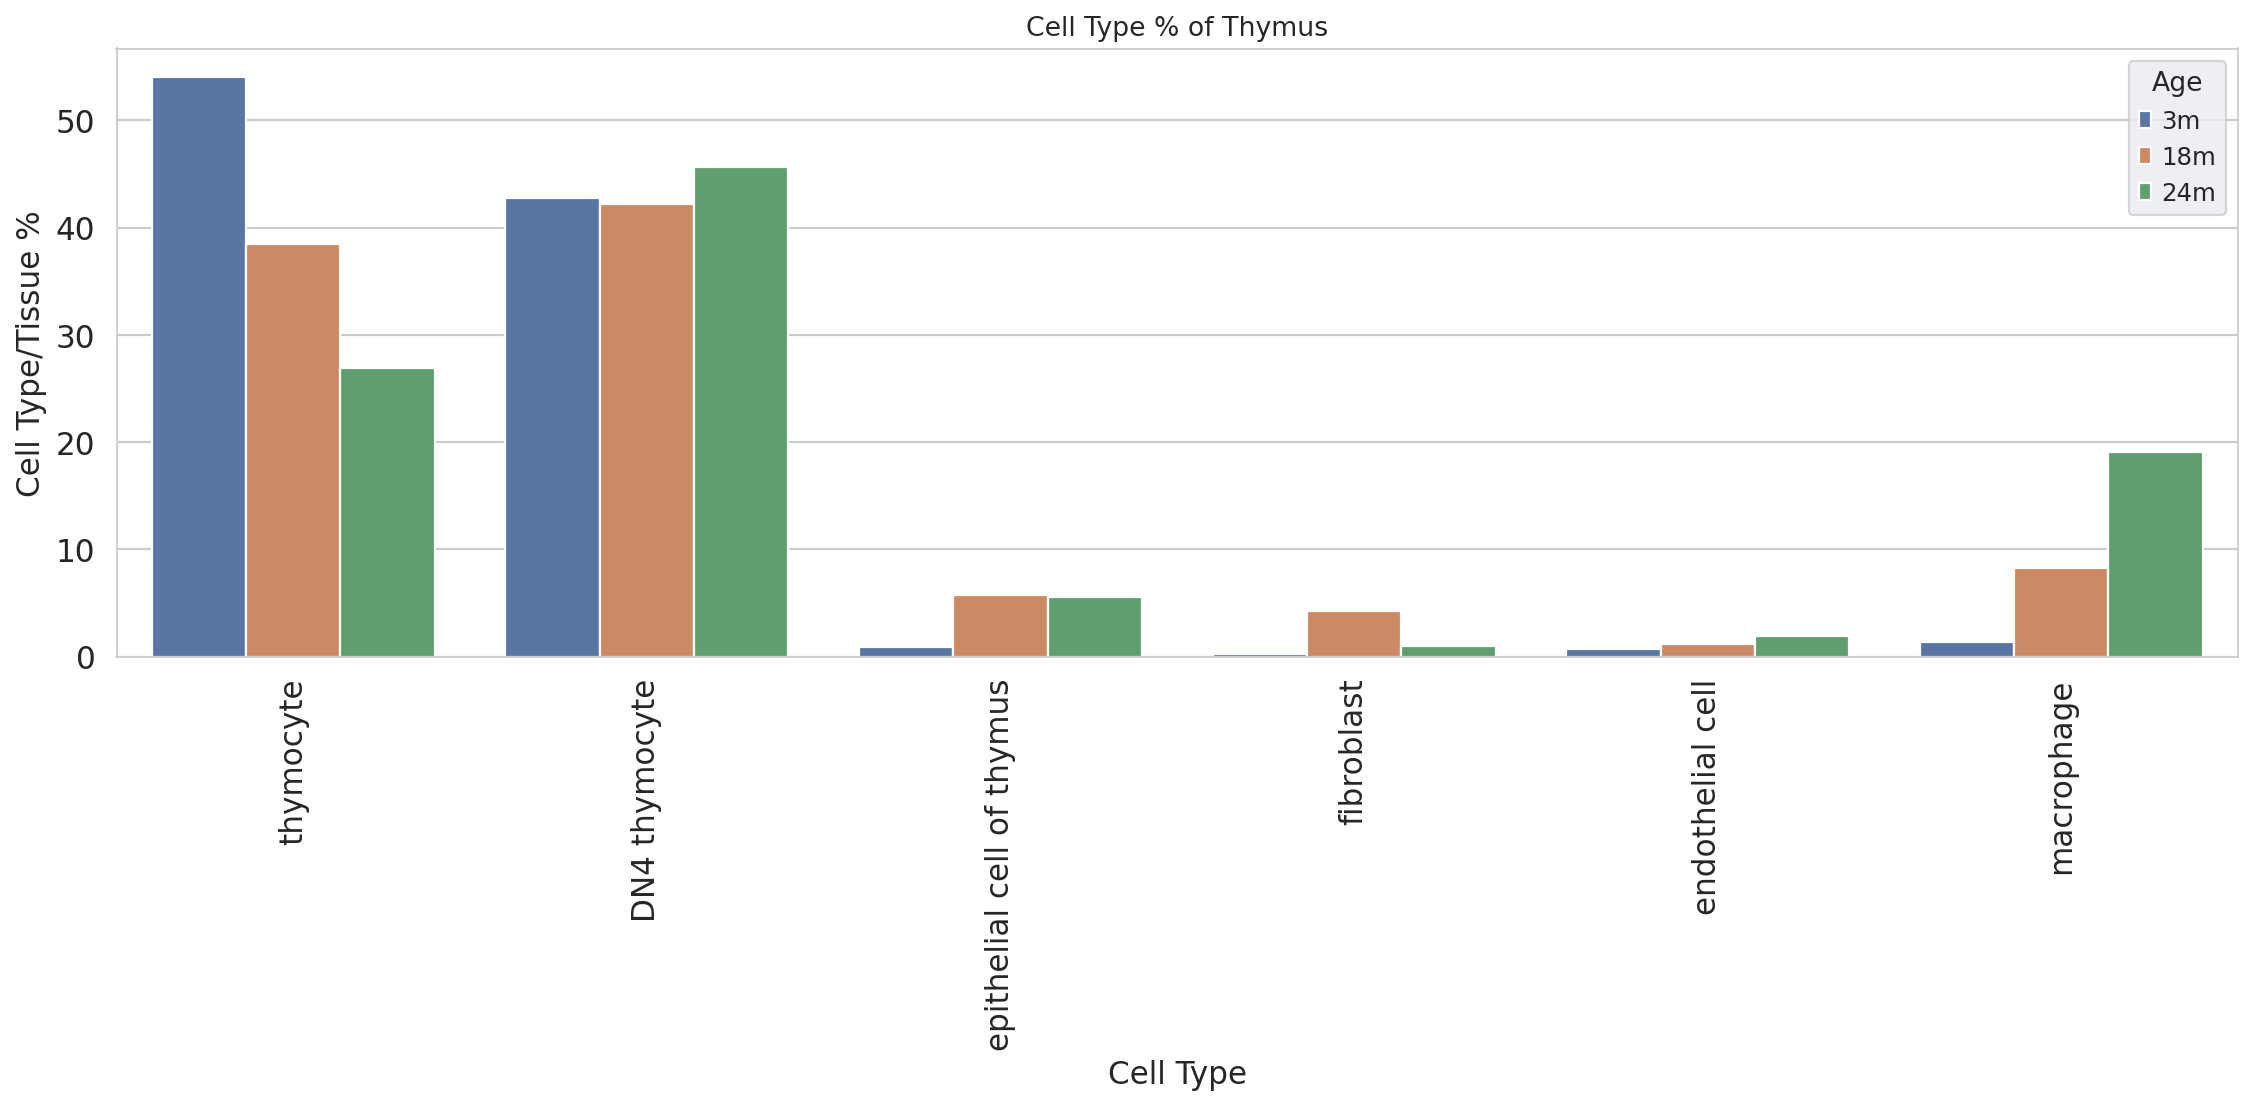

In [155]:
df = cell_per_tissue(tis_cells,tissue)

sns.set_style('whitegrid')
fig = plt.figure(figsize=(17, 5))
plt.xticks(rotation=90)
sns.set(font_scale =1)
sns.barplot(data=df, y="Cell Type/Tissue %", x="Cell Type", hue = "Age").set(title="Cell Type % of Thymus")

In [156]:
mouse_ids = list(set(tissue.obs['mouse.id']))

In [157]:
from collections import defaultdict

def cell_per_tissue2(a_list, adata):
    ''' Input is list and adata tissue object. Output is a pandas DataFrame 
    of the percentage of that cell type for inputted subsetted adata tissue object'''
    
    data = defaultdict(list)
    
    for a in a_list:
        b = adata[adata.obs['mouse.id']== a]#filter by mouse
        for c in tis_cells:       
            d = b[b.obs['cell_ontology_class']== c]#have adata filtered by cell types in list
            tissue_cell_count = b.n_obs
            
            data["mouse.id"].append(a)
            data["Cell Type"].append(c)
            data["Cell Count"].append(d.n_obs)
            data["Cell Type/Tissue %"].append((d.n_obs/b.n_obs)*100)
            
    df = pd.DataFrame(data)
    return df

In [158]:
df2=cell_per_tissue2(mouse_ids,tissue)

In [ ]:
#help(pd.DataFrame.agg)

In [ ]:
#help(pd.DataFrame.groupby)

In [ ]:
#help(pd.DataFrame.aggregate)

In [159]:
df2.groupby(["mouse.id"])[["Cell Type/Tissue %"]].sum()#don't think i need
dd = df2.groupby(["mouse.id", "Cell Type"]).sum()

In [160]:
dd = dd.reset_index('Cell Type')

Pivoting pandas DataFrame so that Cell Type column values becomes columns, and Cell Type/Tissue % populate new columns.

In [161]:
tmp = dd.pivot_table(values='Cell Type/Tissue %', columns="Cell Type", index=dd.index)

Reordering mouse.id X axis

In [162]:
mouse_id_order = [
    '3_8_M', 
    '3_9_M',
    '3_11_M', 
    '3_38_F', 
    '3_39_F', 
    '18_45_M', 
    '18_46_F', 
    '18_47_F', 
    '18_53_M', 
    '24_58_M', 
    '24_59_M',
    '24_60_M', 
    '24_61_M', 
]

tmp = tmp.reindex(mouse_id_order)

**Cell Type % of Thymus per Mouse**

<ipython-input-163-1a8c41979784>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


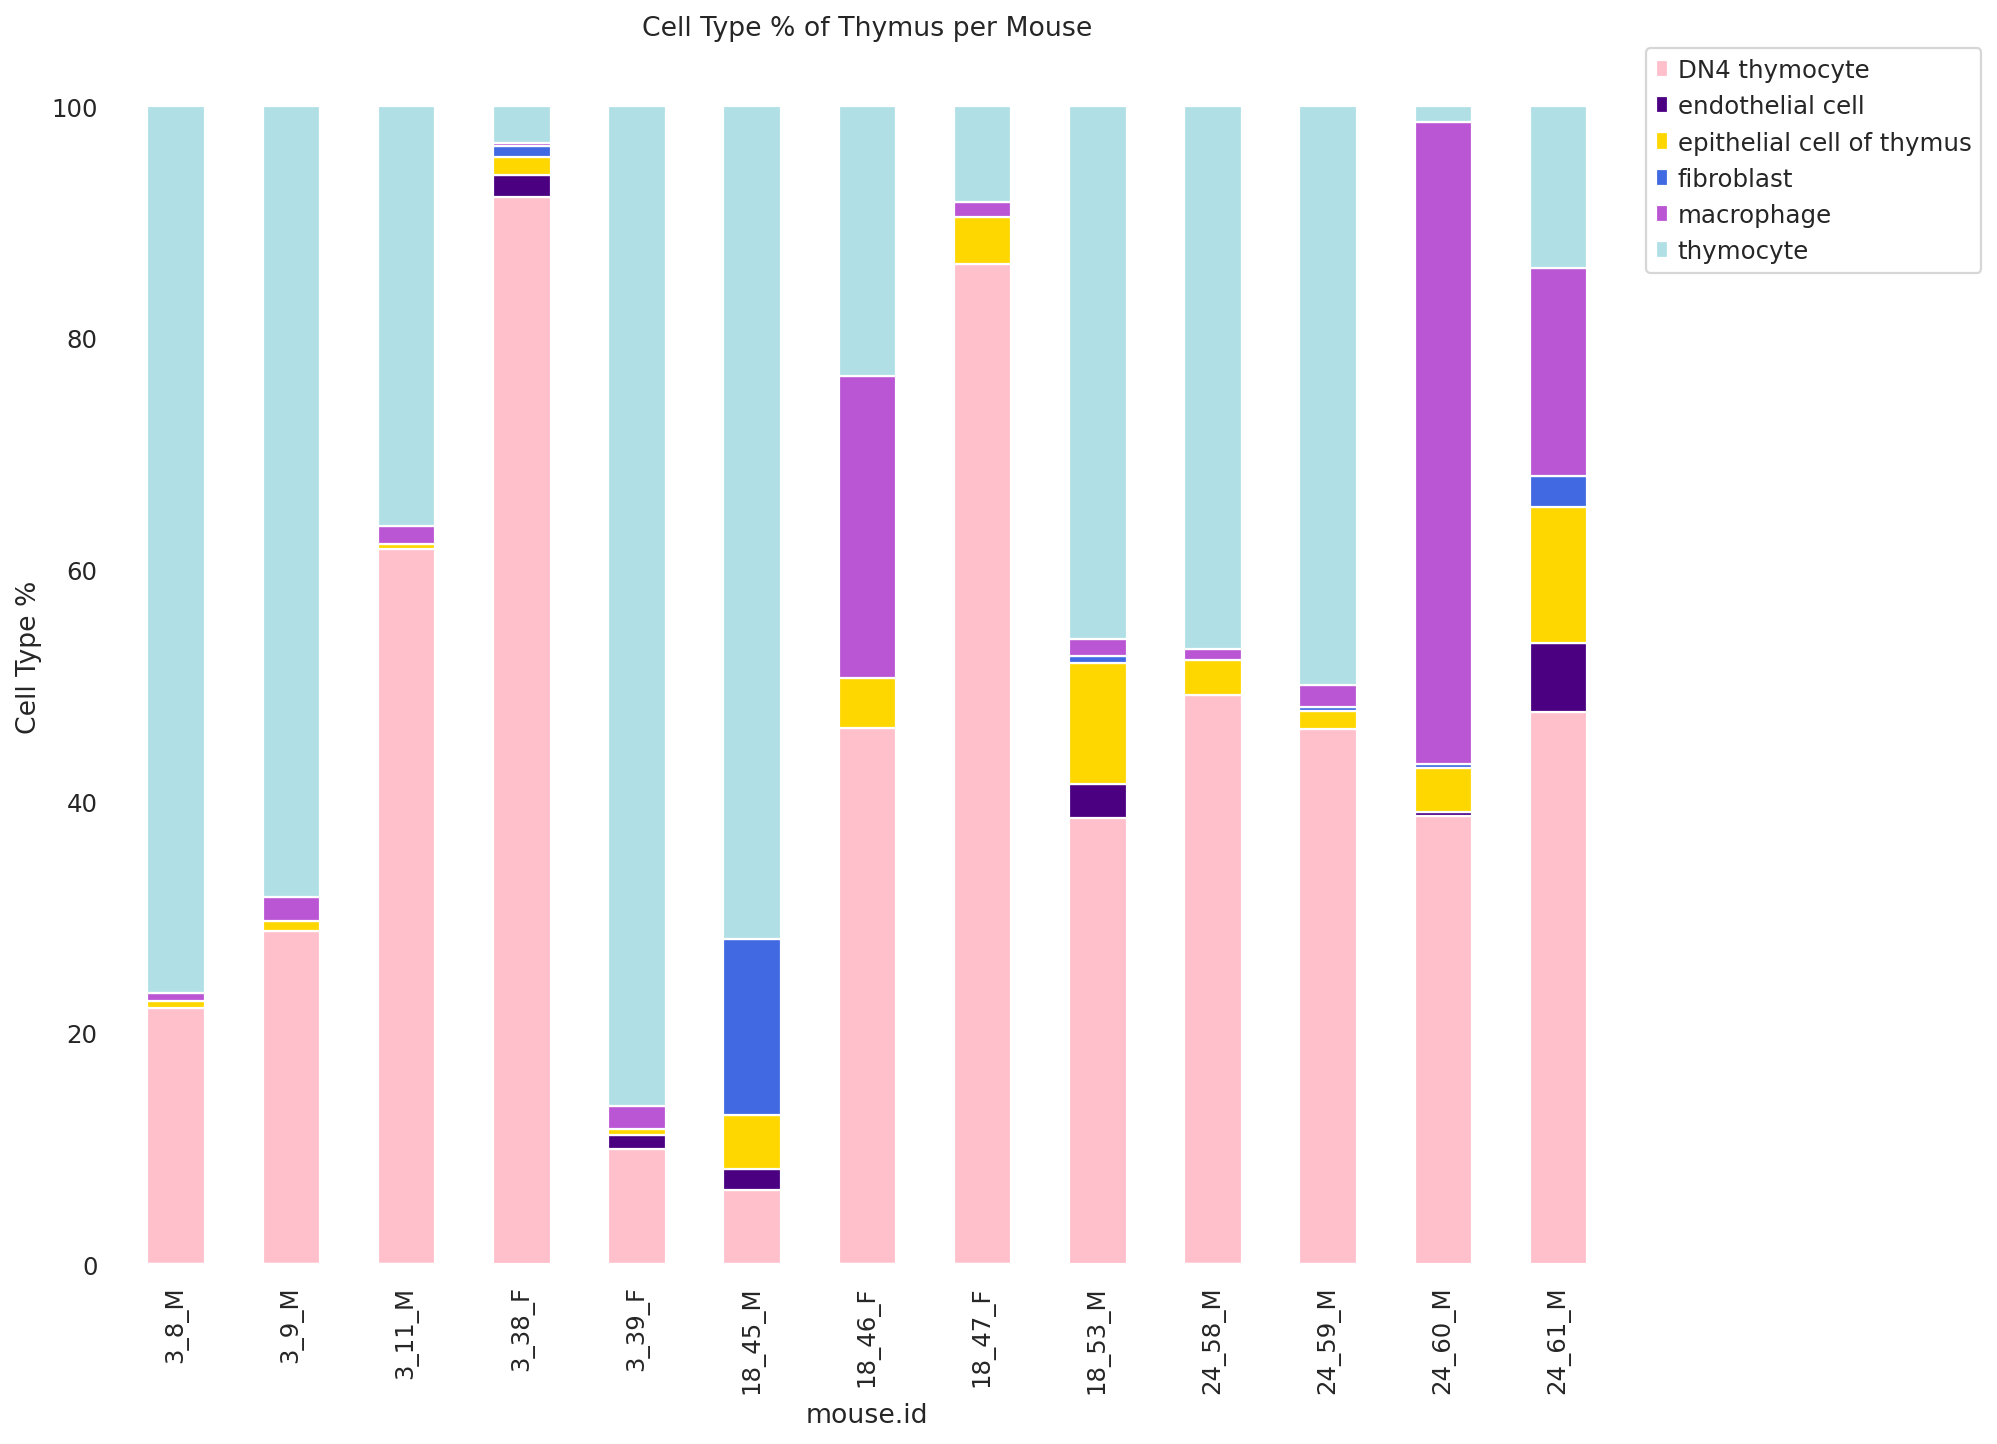

In [163]:
tmp.plot(kind='bar', stacked=True, figsize=(12, 10), color = ['pink','indigo','gold','royalblue','mediumorchid','powderblue'])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, facecolor = 'white')
plt.title("Cell Type % of Thymus per Mouse")
plt.ylabel('Cell Type %')
ax = plt.axes()
ax.set_facecolor("white")


**Cell Type % of Thymus by Age**

In [164]:
from collections import defaultdict

def cell_per_age(a_list, adata):
    ''' Input is list and adata tissue object. Output is a pandas DataFrame 
    of the percentage of that cell type by age for inputted subsetted adata tissue object'''
    
    data = defaultdict(list)
    
    for a in a_list:
        b = adata[adata.obs['age']== a]#filter by age
        for c in tis_cells:       
            d = b[b.obs['cell_ontology_class']== c]#have adata filtered by cell types in list
            tissue_cell_count = b.n_obs
            
            data["age"].append(a)
            data["Cell Type"].append(c)
            #data["Cell Count"].append(d.n_obs)
            data["Cell Type/Tissue %"].append((d.n_obs/b.n_obs)*100)
            
    df = pd.DataFrame(data)
    return df

In [165]:
ac = cell_per_age(ages,tissue)

In [166]:
ad = ac.groupby(["age", "Cell Type"]).sum()

In [167]:
ad = ad.reset_index('Cell Type')

In [168]:
ae = ad.pivot_table(values='Cell Type/Tissue %', columns="Cell Type", index=ad.index)
ae = ae.reindex(ages)

<ipython-input-169-8b10e0581ed1>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


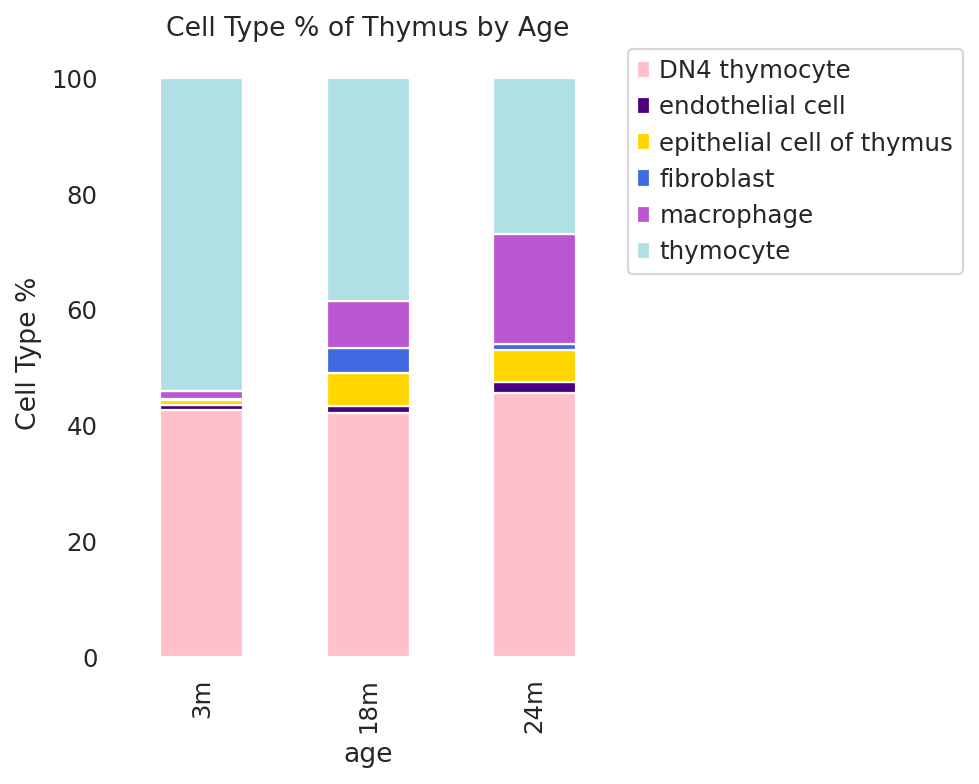

In [169]:
ae.plot(kind='bar', stacked=True, figsize=(4, 5), color = ['pink','indigo','gold','royalblue','mediumorchid','powderblue'])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, facecolor = 'white')
plt.title("Cell Type % of Thymus by Age")
plt.ylabel('Cell Type %')
ax = plt.axes()
ax.set_facecolor("white")

**Variance of Cell Type % of Thymus across Age**

* I'd like to break apart the macrophage cluster (shows two leiden clusters) into two categories and plot

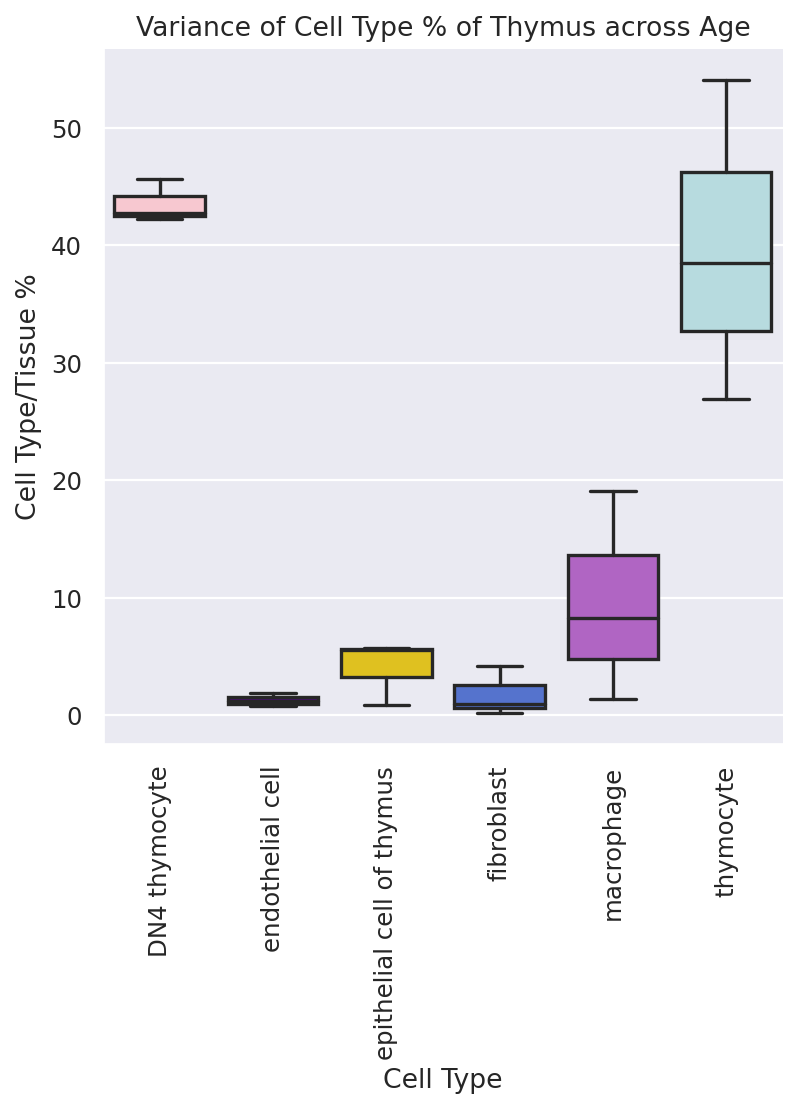

In [170]:
sns.catplot(data = ad, x = 'Cell Type', y = 'Cell Type/Tissue %', kind = "box", palette=sns.color_palette(['pink','indigo','gold','royalblue','mediumorchid','powderblue']))
plt.title("Variance of Cell Type % of Thymus across Age")
sns.set_style("whitegrid")
plt.xticks(rotation=90);


In [ ]:
def remove_cats(adata):

    cat_columns = adata.obs.select_dtypes(['category']).columns
    adata.obs[cat_columns] = adata.obs[cat_columns].astype(str)
    
    return adata

In [ ]:
tissue = remove_cats(tissue)

In [ ]:
'''Angela showing me some pandas tricks and suggestions'''

pd.DataFrame(tissue2.obs.groupby(["age",'mouse.id', 'cell_ontology_class']).agg({"mouse.id":[len]}))
#make a dataframe and count by mouse.id, aggregate
#seaborn, 3 columns x = cell, hue =age y = len

# Gene lists for macrophage subtypes

**The transcription factor NR4A1 is essential for the development of a novel macrophage subset in the thymus** by Tacke et al.

https://pubmed.ncbi.nlm.nih.gov/26091486/
2015 Jun 19;5:10055.
doi: 10.1038/srep10055. 

In [ ]:
'''Thymic macropahge subset of CD11b−F4/80+'''

CD11b_neg_F4_80_pos_express = ['Tim4','CD45', 'CSF1R','Mertk', 'CD64','MHCII']
#enrichment Axl, Tyro3, Mfg-e8
CD11b_neg_F4_80_pos_repress = ['Ly6C','CD11c','Siglec F','Ly6G', 'Dx5','B220']


"Tim4 was used as a marker for thymic CD11b−F4/80+ cells during the histological analysis due to the exclusive expression within this population in the thymus."

# ID macrophage subtype clusters

# Characterize alterations of macropahge MT reads across ages

The **MitoCarta3.0** mouse inventory is a collection of 1140 nuclear and mtDNA genes encoding proteins with strong support of mitochondrial localization. This table provides a summary of evidence supporting mitochondrial localization, the protein distribution across 14 tissues, as well as annotation of biological pathways (based on manual literature review) and sub-compartment (based on annotator's "best guess" integrating sequence features, experimental data, literature, and pathway context; note all subunits of protein complexes are assigned the same compartment). The genes are ordered by strength of mitochondrial evidence. More complete information is available for download in file Mouse.MitoCarta3.0.xls. See also MitoCarta3.0 home for a description of the project and MitoCarta3.0 documentation for information on the columns below. 

In [ ]:
help(sc.pp.highly_variable_genes)

## MitoCarta3.0 Gene List

In [171]:
mitocarta3_path = "/mnt/ibm_sm/home/lea.mcgeever/ms/notebooks/Mouse_mt_genes.csv"
mitocarta3_df = pd.read_csv(mitocarta3_path)
mt_nc_genes = list(mitocarta3_df['Symbol'])

## Gene lists

In [172]:
mt_genes = [
    "mt-Atp6",
    "mt-Atp8",
    "mt-Co1",
    "mt-Co2",
    "mt-Co3",
    "mt-Cytb",
    "mt-Nd1",
    "mt-Nd2",
    "mt-Nd3",
    "mt-Nd4",
    "mt-Nd4l",
    "mt-Nd5",
    "mt-Nd6",
    "mt-Rnr1",
    "mt-Rnr2",
    "mt-Ta",
    "mt-Te",
    "mt-Tf",
    "mt-Ti",
    "mt-Tl1",
     "mt-Tl2",
    "mt-Tm",
    "mt-Tp",
    "mt-Tq",
    "mt-Tt",
    "mt-Tv"
]

mitocarta_remove = ["mt-Atp6",
                    "mt-Atp8",
                    "mt-Co1",
                    "mt-Co2",
                    "mt-Co3",
                    "mt-Cytb",
                    "mt-Nd1",
                    "mt-Nd2",
                    "mt-Nd3",
                    "mt-Nd4",
                    "mt-Nd4l",
                    "mt-Nd5",
                    "mt-Nd6"]

#removing mt_encoded genes
for m in mitocarta_remove:
    mt_nc_genes.remove(m)

Genes not in adata.vars

In [173]:
#sc.tl.score_genes_cell_cycle ignored these genes since they're not in .vars
ignored = ['Gatd3a', 'Micos10', 'Fdx2', 'Mmut', 'Atp5pb', 'Mtarc2', 'Micos13', 'Mtres1', 'Coa8', 'Tmlhe', 'Mtarc1', 'Prxl2a', 'Marchf5', 'Dmac2l', 'Atp5md', 'Antkmt', 'Atpsckmt', 'Septin4', 'Prorp', 'Htd2', 'Pigbos1']


Mitocarta3.0 nuclear genes combined with mitochondrial genes

In [174]:
mt_nc = mt_genes + mt_nc_genes

## Gene expression dataframe

In [175]:
def gene_expression_df(adata, genelist):
    '''Takes adata object and a list of genes. 
    Returns a pandas dataframe where genes and their expression values are columns in dataframe of adata.'''
    df = adata.obs.copy()
    
    for g in genelist:
        df[g] = tissue[:,g].X.toarray().flatten()
    return df   

In [176]:
'''Removing genes from MitoCarta gene list that are not in .vars'''

genes = list(mt_nc.copy())

for i in range(len(ignored)):
    for i in ignored:
        if i in genes:
            genes.remove(i)   

In [177]:
'''Checking for duplicate genes'''
dupe_genes = []
for g in genes:
    count = genes.count(g)
    if count > 1:
        dupe_genes.append(g)
print(f'There are {len(dupe_genes)} duplicate genes in genes list')

There are 0 duplicate genes in genes list


In [ ]:
'''Checking that all MT genes are in genes (mt_nc) list'''

for m in mt_genes:
    if m in genes:
        print(m,'yes')
    else:
        print(m, 'no') 

In [ ]:
#may be too large?
df_nc_mt = gene_expression_df(tissue_sg1,list(tissue_sg1.var.index))

In [ ]:
df_nc_mt['Nr4a1']

## MT and MitoCarta score_genes

**Function for looping through MT and Mitocarta gene list for sc.tl.score_genes()**

In [ ]:
help(sc.tl.score_genes_cell_cycle)

**Save MT score_genes result** (unhash if doing for the first time)

* score_genes_cell_cycle(adata, s_genes, g2m_genes)
* mt_genes -> s_genes
* mt_nc_genes -> g2m_genes

In [186]:
#tissue_score_genes = sc.tl.score_genes_cell_cycle(tissue, mt_genes, mt_nc_genes, copy = True)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    234 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    505 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [187]:
tissue_score_genes_path = "/mnt/ibm_sm/home/lea.mcgeever/ms/notebooks/adata_files/tissue_sg1_02172022.h5ad"
#tissue_sg1.write(tissue_score_genes_path)

In [188]:
tissue_sg1 = sc.read_h5ad(tissue_score_genes_path)

In [ ]:
tissue_sg1.obs[['age','cell_ontology_class','S_score','G2M_score']]

Checking out the distribution gene_score for "mt-Nd4" gene

<AxesSubplot:ylabel='Count'>

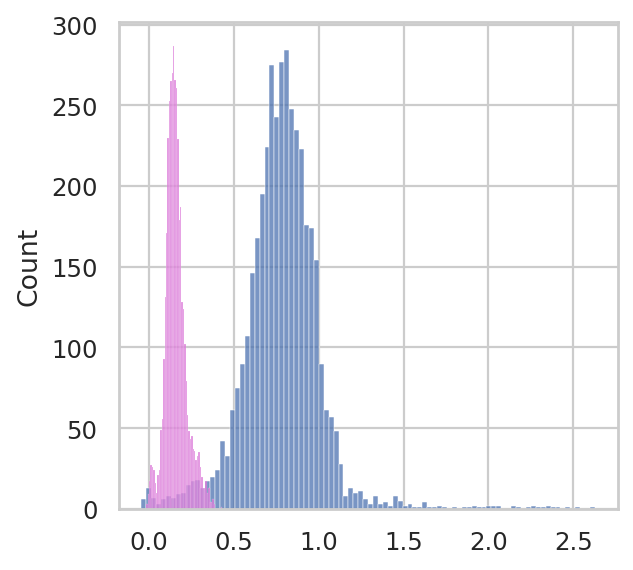

In [191]:
sns.histplot(list(tissue_sg1.obs["S_score"]))#mitochondria
sns.histplot(list(tissue_sg1.obs["G2M_score"]), color = 'orchid')#nuclear

A function to make a dataframe of gene_scores and gene expression score by cell

In [148]:
def cell_gene_exp_df(gene, adata):
    ''' Input is gene name that has an obs.gene_score. 
    Output is a pandas DataFrame with two columns: cell index and gene's gene_score'''
    
    data = defaultdict(list)
    
    for d in list(adata.obs['cell']):
        data["Cell"].append(d)
        
        cg = adata[adata.obs.cell == d, adata.var.index == gene]
        data["Gene Expression"].append(cg.X[0,0]) 
    
    #for g in list(adata.obs[gene]):
    #    data["gene_score"].append(g)
       
    df = pd.DataFrame(data)
    return df

* Check this out!  

tissue_sg1 is after using it. sc.tl.score_genes_cell_cycle seems to change the Gene Expression values. 

tissue is the adata before using sc.tl.score_genes_cell_cycle.

In [189]:
cell_gene_exp_df('Nr4a1',tissue_sg1)

,Cell,Gene Expression
0,A10.MAA000609.3_8_M.1.1,-0.625617
1,A13.MAA000609.3_8_M.1.1,-0.640107
2,A21.MAA000609.3_8_M.1.1,-0.624484
3,A22.MAA000609.3_8_M.1.1,-0.640107
4,A3.MAA000609.3_8_M.1.1,-0.635712
...,...,...
4027,M20_B000235,-0.640107
4028,M21_B000235,-0.640107
4029,M22_B000235,-0.640107
4030,N18_B000235,-0.217686


In [190]:
cell_gene_exp_df('Nr4a1',tissue)

,Cell,Gene Expression
0,A10.MAA000609.3_8_M.1.1,0.017852
1,A13.MAA000609.3_8_M.1.1,0.000000
2,A21.MAA000609.3_8_M.1.1,0.019248
3,A22.MAA000609.3_8_M.1.1,0.000000
4,A3.MAA000609.3_8_M.1.1,0.005416
...,...,...
4027,M20_B000235,0.000000
4028,M21_B000235,0.000000
4029,M22_B000235,0.000000
4030,N18_B000235,0.520420


gene_score:

The score is the average expression of a set of genes subtracted with the
    average expression of a reference set of genes. The reference set is
    randomly sampled from the `gene_pool` for each binned expression value.

**tissue_gene_scores** had 50 genes for score_genes and no random state set.

* Get mean of scored genes and see what's most varied.
* Compare ages of mean scores against all ages
* subset by age, see how genes score and vary within age groups and compare that against other ages
* Redo score_genes with a few diff random seeds and more genes to make sure results still hold


## score_genes analysis

Load Thymus adata w/ S_score & G2M_score

In [ ]:
tissue_score_genes_path = "/mnt/ibm_sm/home/lea.mcgeever/ms/notebooks/adata_files/tissue_sg1_02172022.h5ad"
tissue_sg1 = sc.read_h5ad(tissue_score_genes_path)

Comparing ages of mean scores against all ages

**Lists**

* tis_cells (thymus cell types)
* ages 
* mt_genes (only mt)
* mt_nc_genes (only nc)

mt_genes -> s_genes

mt_nc_genes -> g2m_genes

## Statistics tests on gene expression

In [ ]:
#I think I need to use a dataframe that has ALL the genes as columns, not just my genes of interest.

In [195]:
df_nc_mt = gene_expression_df(tissue,genes)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

macrophage_3m v.s. macrophage_18m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=8.610e+02
macrophage_18m v.s. macrophage_24m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.340e-03 U_stat=1.033e+04
endothelial cell_18m v.s. endothelial cell_24m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.210e+02
epithelial cell of thymus_3m v.s. epithelial cell of thymus_18m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.880e+02
epithelial cell of thymus_18m v.s. epithelial cell of thymus_24m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.396e-01 U_stat=2.127e+03
fibroblast_3m v.s. fibroblast_18m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correcti

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'DN4 thymocyte'),
  Text(1, 0, 'endothelial cell'),
  Text(2, 0, 'epithelial cell of thymus'),
  Text(3, 0, 'fibroblast'),
  Text(4, 0, 'macrophage'),
  Text(5, 0, 'thymocyte')])

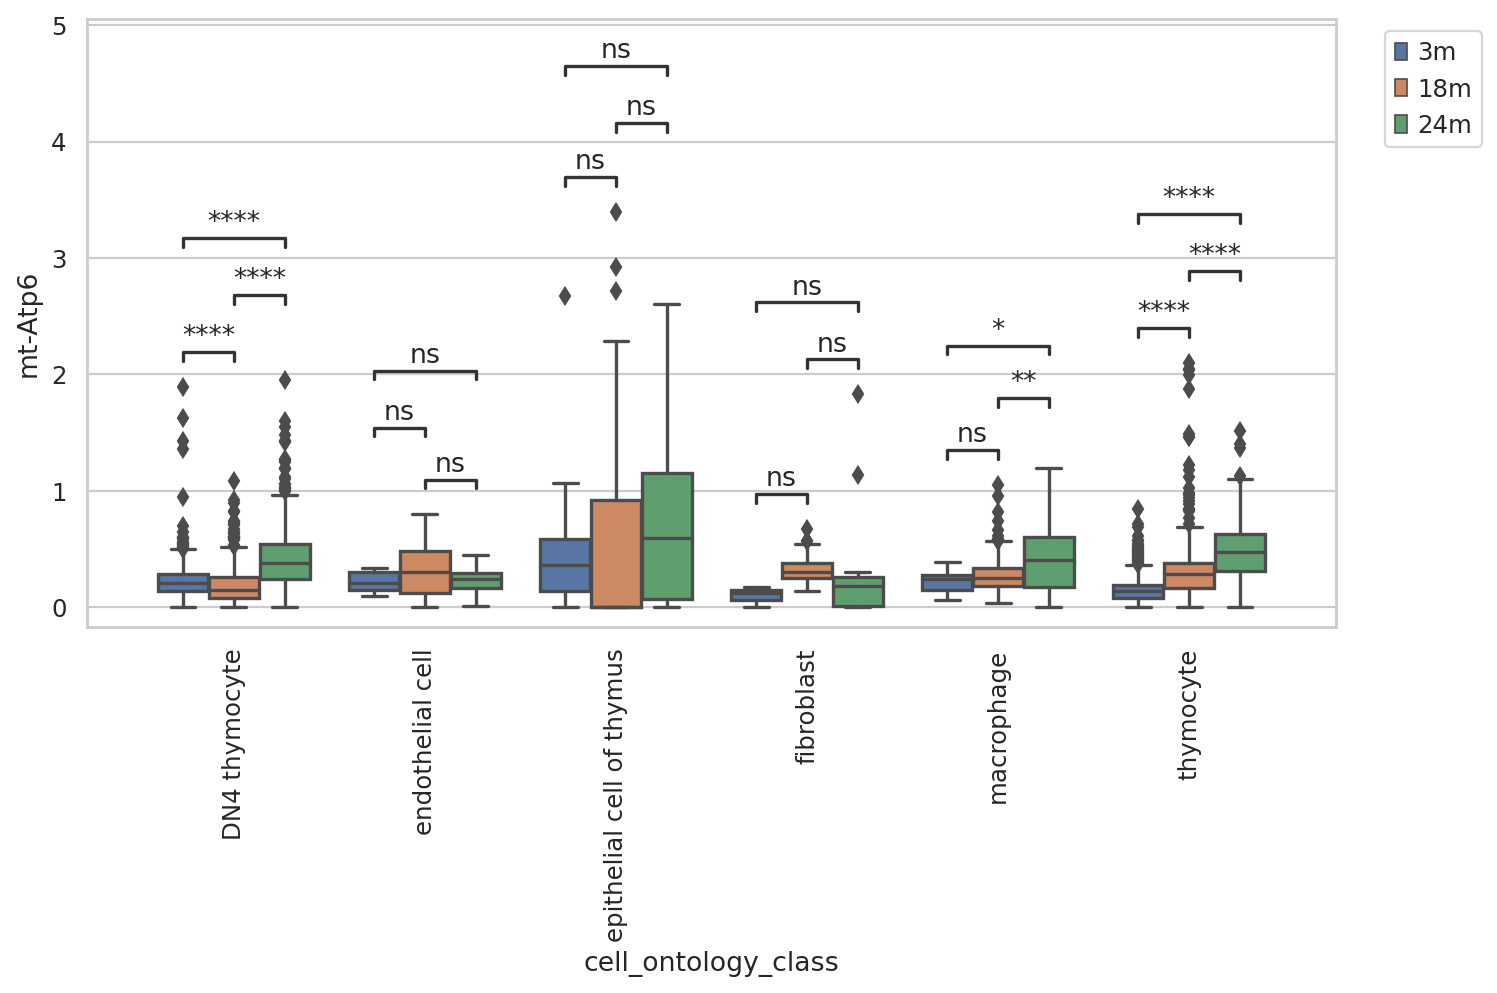

In [196]:
df = df_nc_mt[['age','cell_ontology_class','mt-Atp6']]

x = "cell_ontology_class" 
y = "mt-Atp6" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("DN4 thymocyte", "3m"), ("DN4 thymocyte", "18m")),
    (("DN4 thymocyte", "3m"), ("DN4 thymocyte", "24m")),
    (("DN4 thymocyte", "18m"), ("DN4 thymocyte", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),
    
    (("epithelial cell of thymus", "3m"), ("epithelial cell of thymus", "18m")),
    (("epithelial cell of thymus", "3m"), ("epithelial cell of thymus", "24m")),
    (("epithelial cell of thymus", "18m"), ("epithelial cell of thymus", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("thymocyte", "3m"), ("thymocyte", "18m")),
    (("thymocyte", "3m"), ("thymocyte", "24m")),
    (("thymocyte", "18m"), ("thymocyte", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)


In [ ]:
df = df_nc_mt[['age','cell_ontology_class','mt-Atp8']]

x = "cell_ontology_class" 
y = "mt-Atp8" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("DN4 thymocyte", "3m"), ("DN4 thymocyte", "18m")),
    (("DN4 thymocyte", "3m"), ("DN4 thymocyte", "24m")),
    (("DN4 thymocyte", "18m"), ("DN4 thymocyte", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),
    
    (("epithelial cell of thymus", "3m"), ("epithelial cell of thymus", "18m")),
    (("epithelial cell of thymus", "3m"), ("epithelial cell of thymus", "24m")),
    (("epithelial cell of thymus", "18m"), ("epithelial cell of thymus", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("thymocyte", "3m"), ("thymocyte", "18m")),
    (("thymocyte", "3m"), ("thymocyte", "24m")),
    (("thymocyte", "18m"), ("thymocyte", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)


In [ ]:
df = df_nc_mt[['age','cell_ontology_class','mt-Co1']]

x = "cell_ontology_class" 
y = "mt-Co1" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("DN4 thymocyte", "3m"), ("DN4 thymocyte", "18m")),
    (("DN4 thymocyte", "3m"), ("DN4 thymocyte", "24m")),
    (("DN4 thymocyte", "18m"), ("DN4 thymocyte", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),
    
    (("epithelial cell of thymus", "3m"), ("epithelial cell of thymus", "18m")),
    (("epithelial cell of thymus", "3m"), ("epithelial cell of thymus", "24m")),
    (("epithelial cell of thymus", "18m"), ("epithelial cell of thymus", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("thymocyte", "3m"), ("thymocyte", "18m")),
    (("thymocyte", "3m"), ("thymocyte", "24m")),
    (("thymocyte", "18m"), ("thymocyte", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)


In [ ]:
df = df_nc_mt[['age','cell_ontology_class','mt-Co2']]

x = "cell_ontology_class" 
y = "mt-Co2" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("DN4 thymocyte", "3m"), ("DN4 thymocyte", "18m")),
    (("DN4 thymocyte", "3m"), ("DN4 thymocyte", "24m")),
    (("DN4 thymocyte", "18m"), ("DN4 thymocyte", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),
    
    (("epithelial cell of thymus", "3m"), ("epithelial cell of thymus", "18m")),
    (("epithelial cell of thymus", "3m"), ("epithelial cell of thymus", "24m")),
    (("epithelial cell of thymus", "18m"), ("epithelial cell of thymus", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("thymocyte", "3m"), ("thymocyte", "18m")),
    (("thymocyte", "3m"), ("thymocyte", "24m")),
    (("thymocyte", "18m"), ("thymocyte", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)


In [ ]:
df = df_nc_mt[['age','cell_ontology_class','mt-Co3']]

x = "cell_ontology_class" 
y = "mt-Co3" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("DN4 thymocyte", "3m"), ("DN4 thymocyte", "18m")),
    (("DN4 thymocyte", "3m"), ("DN4 thymocyte", "24m")),
    (("DN4 thymocyte", "18m"), ("DN4 thymocyte", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),
    
    (("epithelial cell of thymus", "3m"), ("epithelial cell of thymus", "18m")),
    (("epithelial cell of thymus", "3m"), ("epithelial cell of thymus", "24m")),
    (("epithelial cell of thymus", "18m"), ("epithelial cell of thymus", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("thymocyte", "3m"), ("thymocyte", "18m")),
    (("thymocyte", "3m"), ("thymocyte", "24m")),
    (("thymocyte", "18m"), ("thymocyte", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)


In [ ]:
df = df_nc_mt[['age','cell_ontology_class','mt-Cytb']]

x = "cell_ontology_class" 
y = "mt-Cytb" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("DN4 thymocyte", "3m"), ("DN4 thymocyte", "18m")),
    (("DN4 thymocyte", "3m"), ("DN4 thymocyte", "24m")),
    (("DN4 thymocyte", "18m"), ("DN4 thymocyte", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),
    
    (("epithelial cell of thymus", "3m"), ("epithelial cell of thymus", "18m")),
    (("epithelial cell of thymus", "3m"), ("epithelial cell of thymus", "24m")),
    (("epithelial cell of thymus", "18m"), ("epithelial cell of thymus", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("thymocyte", "3m"), ("thymocyte", "18m")),
    (("thymocyte", "3m"), ("thymocyte", "24m")),
    (("thymocyte", "18m"), ("thymocyte", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)


In [ ]:
df = df_nc_mt[['age','cell_ontology_class','mt-Nd1']]

x = "cell_ontology_class" 
y = "mt-Nd1" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("DN4 thymocyte", "3m"), ("DN4 thymocyte", "18m")),
    (("DN4 thymocyte", "3m"), ("DN4 thymocyte", "24m")),
    (("DN4 thymocyte", "18m"), ("DN4 thymocyte", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),
    
    (("epithelial cell of thymus", "3m"), ("epithelial cell of thymus", "18m")),
    (("epithelial cell of thymus", "3m"), ("epithelial cell of thymus", "24m")),
    (("epithelial cell of thymus", "18m"), ("epithelial cell of thymus", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("thymocyte", "3m"), ("thymocyte", "18m")),
    (("thymocyte", "3m"), ("thymocyte", "24m")),
    (("thymocyte", "18m"), ("thymocyte", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)


In [ ]:
df = df_nc_mt[['age','cell_ontology_class','mt-Nd2']]

x = "cell_ontology_class" 
y = "mt-Nd2" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("DN4 thymocyte", "3m"), ("DN4 thymocyte", "18m")),
    (("DN4 thymocyte", "3m"), ("DN4 thymocyte", "24m")),
    (("DN4 thymocyte", "18m"), ("DN4 thymocyte", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),
    
    (("epithelial cell of thymus", "3m"), ("epithelial cell of thymus", "18m")),
    (("epithelial cell of thymus", "3m"), ("epithelial cell of thymus", "24m")),
    (("epithelial cell of thymus", "18m"), ("epithelial cell of thymus", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("thymocyte", "3m"), ("thymocyte", "18m")),
    (("thymocyte", "3m"), ("thymocyte", "24m")),
    (("thymocyte", "18m"), ("thymocyte", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)


In [ ]:
df = df_nc_mt[['age','cell_ontology_class','mt-Nd3']]

x = "cell_ontology_class" 
y = "mt-Nd3" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("DN4 thymocyte", "3m"), ("DN4 thymocyte", "18m")),
    (("DN4 thymocyte", "3m"), ("DN4 thymocyte", "24m")),
    (("DN4 thymocyte", "18m"), ("DN4 thymocyte", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),
    
    (("epithelial cell of thymus", "3m"), ("epithelial cell of thymus", "18m")),
    (("epithelial cell of thymus", "3m"), ("epithelial cell of thymus", "24m")),
    (("epithelial cell of thymus", "18m"), ("epithelial cell of thymus", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("thymocyte", "3m"), ("thymocyte", "18m")),
    (("thymocyte", "3m"), ("thymocyte", "24m")),
    (("thymocyte", "18m"), ("thymocyte", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)


In [ ]:
df = df_nc_mt[['age','cell_ontology_class','mt-Nd4']]

x = "cell_ontology_class" 
y = "mt-Nd4" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("DN4 thymocyte", "3m"), ("DN4 thymocyte", "18m")),
    (("DN4 thymocyte", "3m"), ("DN4 thymocyte", "24m")),
    (("DN4 thymocyte", "18m"), ("DN4 thymocyte", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),
    
    (("epithelial cell of thymus", "3m"), ("epithelial cell of thymus", "18m")),
    (("epithelial cell of thymus", "3m"), ("epithelial cell of thymus", "24m")),
    (("epithelial cell of thymus", "18m"), ("epithelial cell of thymus", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("thymocyte", "3m"), ("thymocyte", "18m")),
    (("thymocyte", "3m"), ("thymocyte", "24m")),
    (("thymocyte", "18m"), ("thymocyte", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)


In [ ]:
df = df_nc_mt[['age','cell_ontology_class','mt-Nd4l']]

x = "cell_ontology_class" 
y = "mt-Nd4l" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("DN4 thymocyte", "3m"), ("DN4 thymocyte", "18m")),
    (("DN4 thymocyte", "3m"), ("DN4 thymocyte", "24m")),
    (("DN4 thymocyte", "18m"), ("DN4 thymocyte", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),
    
    (("epithelial cell of thymus", "3m"), ("epithelial cell of thymus", "18m")),
    (("epithelial cell of thymus", "3m"), ("epithelial cell of thymus", "24m")),
    (("epithelial cell of thymus", "18m"), ("epithelial cell of thymus", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("thymocyte", "3m"), ("thymocyte", "18m")),
    (("thymocyte", "3m"), ("thymocyte", "24m")),
    (("thymocyte", "18m"), ("thymocyte", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)


In [ ]:
df = df_nc_mt[['age','cell_ontology_class','mt-Nd5']]

x = "cell_ontology_class" 
y = "mt-Nd5" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("DN4 thymocyte", "3m"), ("DN4 thymocyte", "18m")),
    (("DN4 thymocyte", "3m"), ("DN4 thymocyte", "24m")),
    (("DN4 thymocyte", "18m"), ("DN4 thymocyte", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),
    
    (("epithelial cell of thymus", "3m"), ("epithelial cell of thymus", "18m")),
    (("epithelial cell of thymus", "3m"), ("epithelial cell of thymus", "24m")),
    (("epithelial cell of thymus", "18m"), ("epithelial cell of thymus", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("thymocyte", "3m"), ("thymocyte", "18m")),
    (("thymocyte", "3m"), ("thymocyte", "24m")),
    (("thymocyte", "18m"), ("thymocyte", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)


In [ ]:
df = df_nc_mt[['age','cell_ontology_class','mt-Nd6']]

x = "cell_ontology_class" 
y = "mt-Nd6" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("DN4 thymocyte", "3m"), ("DN4 thymocyte", "18m")),
    (("DN4 thymocyte", "3m"), ("DN4 thymocyte", "24m")),
    (("DN4 thymocyte", "18m"), ("DN4 thymocyte", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),
    
    (("epithelial cell of thymus", "3m"), ("epithelial cell of thymus", "18m")),
    (("epithelial cell of thymus", "3m"), ("epithelial cell of thymus", "24m")),
    (("epithelial cell of thymus", "18m"), ("epithelial cell of thymus", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("thymocyte", "3m"), ("thymocyte", "18m")),
    (("thymocyte", "3m"), ("thymocyte", "24m")),
    (("thymocyte", "18m"), ("thymocyte", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)


In [ ]:
df = df_nc_mt[['age','cell_ontology_class','mt-Rnr1']]

x = "cell_ontology_class" 
y = "mt-Rnr1" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("DN4 thymocyte", "3m"), ("DN4 thymocyte", "18m")),
    (("DN4 thymocyte", "3m"), ("DN4 thymocyte", "24m")),
    (("DN4 thymocyte", "18m"), ("DN4 thymocyte", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),
    
    (("epithelial cell of thymus", "3m"), ("epithelial cell of thymus", "18m")),
    (("epithelial cell of thymus", "3m"), ("epithelial cell of thymus", "24m")),
    (("epithelial cell of thymus", "18m"), ("epithelial cell of thymus", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("thymocyte", "3m"), ("thymocyte", "18m")),
    (("thymocyte", "3m"), ("thymocyte", "24m")),
    (("thymocyte", "18m"), ("thymocyte", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)


In [ ]:
df = df_nc_mt[['age','cell_ontology_class','mt-Rnr2']]

x = "cell_ontology_class" 
y = "mt-Rnr2" 
hue = 'age'
hue_order = ['3m', '18m', '24m']

box_pairs=[
    (("macrophage", "3m"), ("macrophage", "18m")),
    (("macrophage", "3m"), ("macrophage", "24m")),
    (("macrophage", "18m"), ("macrophage", "24m")),
    
    (("DN4 thymocyte", "3m"), ("DN4 thymocyte", "18m")),
    (("DN4 thymocyte", "3m"), ("DN4 thymocyte", "24m")),
    (("DN4 thymocyte", "18m"), ("DN4 thymocyte", "24m")),
    
    (("endothelial cell", "3m"), ("endothelial cell", "18m")),
    (("endothelial cell", "3m"), ("endothelial cell", "24m")),
    (("endothelial cell", "18m"), ("endothelial cell", "24m")),
    
    (("epithelial cell of thymus", "3m"), ("epithelial cell of thymus", "18m")),
    (("epithelial cell of thymus", "3m"), ("epithelial cell of thymus", "24m")),
    (("epithelial cell of thymus", "18m"), ("epithelial cell of thymus", "24m")),
    
    (("fibroblast", "3m"), ("fibroblast", "18m")),
    (("fibroblast", "3m"), ("fibroblast", "24m")),
    (("fibroblast", "18m"), ("fibroblast", "24m")),
    
    (("thymocyte", "3m"), ("thymocyte", "18m")),
    (("thymocyte", "3m"), ("thymocyte", "24m")),
    (("thymocyte", "18m"), ("thymocyte", "24m")),
    ]
fig = plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=df, x=x, y=y, hue=hue)
add_stat_annotation(ax, data=df, x=x, y=y,hue=hue,box_pairs=box_pairs,
                    test='Mann-Whitney',loc='inside',verbose=2)

plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.xticks(rotation=90)


## Will probably delete funtions below

In [ ]:
#mt_genes -> s_genes
#mt_nc_genes -> g2m_genes

def S_G2M_score_dy(adata):
    ''' Input is adata. Output is a dictionary with keys: 
        Age, Cell Type, N (number of cells), 
        "mt scores": value of list of score_genes for S_genes (mt genes) and
        "nc scores": value of G2M_genes(nc encoded mt genes)'''
    
    data = defaultdict(list)
    
    for a in ages:
        b = adata[adata.obs['age']== a]#filter by age
        for e in tis_cells:#going through keys/tissue types       
            c = b[b.obs['cell_ontology_class']== e]#have adata filtered by cell types in list
            f = list(c.obs['S_score'])
            g = list(c.obs['G2M_score'])
            
            data["Age"].append(a)
            data["Cell Type"].append(e)
            data['N'].append(c.n_obs) 
            data["mt scores"].append(f) 
            data["nc scores"].append(g)
    
    return data

In [ ]:
scores_dy = S_G2M_score_dy(tissue_sg1)

**Function for dictionary for individual MT gene t-test**

In [ ]:
def MT_score_dy(adata):
    ''' Input is adata. Output is a dictionary with columns: 
        Age, Cell Type, N (number of cells), 
        MT genes with list of score per cell type.'''
    
    data = defaultdict(list)
    
    for a in ages:
        b = adata[adata.obs['age']== a]#filter by age
        for e in tis_cells:#going through keys/tissue types       
            c = b[b.obs['cell_ontology_class']== e]#have adata filtered by cell types in list
            
            data["Age"].append(a)
            data["Cell Type"].append(e)
            data['N'].append(c.n_obs) 
            data['mt-Atp6'].append(list(set(c.obs['mt-Atp6'])))
            data['mt-Atp8'].append(list(set(c.obs['mt-Atp8'])))
            data['mt-Co1'].append(list(set(c.obs['mt-Co1'])))
            data['mt-Co2'].append(list(set(c.obs['mt-Co2'])))
            data['mt-Co3'].append(list(set(c.obs['mt-Co3'])))
            data['mt-Cytb'].append(list(set(c.obs['mt-Cytb'])))
            data['mt-Nd1'].append(list(set(c.obs['mt-Nd1'])))
            data['mt-Nd2'].append(list(set(c.obs['mt-Nd2'])))
            data['mt-Nd3'].append(list(set(c.obs['mt-Nd3'])))
            data['mt-Nd4'].append(list(set(c.obs['mt-Nd4'])))
            data['mt-Nd4l'].append(list(set(c.obs['mt-Nd4l'])))
            data['mt-Nd5'].append(list(set(c.obs['mt-Nd5'])))
            data['mt-Nd6'].append(list(set(c.obs['mt-Nd6'])))
            data['mt-Rnr1'].append(list(set(c.obs['mt-Rnr1'])))
            data['mt-Rnr2'].append(list(set(c.obs['mt-Rnr2'])))
            data['mt-Ta'].append(list(set(c.obs['mt-Ta'])))
            data['mt-Te'].append(list(set(c.obs['mt-Te'])))
            data['mt-Tf'].append(list(set(c.obs['mt-Tf'])))
            data['mt-Ti'].append(list(set(c.obs['mt-Ti'])))
            data['mt-Tl1'].append(list(set(c.obs['mt-Tl1'])))
            data['mt-Tl2'].append(list(set(c.obs['mt-Tl2'])))
            data['mt-Tm'].append(list(set(c.obs['mt-Tm'])))
            data['mt-Tp'].append(list(set(c.obs['mt-Tp'])))
            data['mt-Tq'].append(list(set(c.obs['mt-Tq'])))
            data['mt-Tt'].append(list(set(c.obs['mt-Tt'])))
            data['mt-Tv'].append(list(set(c.obs['mt-Tv'])))
        
    
    return data

In [ ]:
mf_dic = MT_score_dy(tissue_mtsg)

**Function for mt gene list t-test**

In [ ]:
def ttest_scores_mt(dictionary):
    '''Input is a dictionary with 'mt scores' for score_genes of mt_genes,  
    
    associated 'Age' and 'Cell Type' columns.
    
    T-test is done between 3m vs. 18m, 3m vs. 24m, and 18m vs. 24m.
    
    Results that have a pvalue equal or less than 0.05 are added to a dictionary.
    
    That dictionary of significant results is returned.'''
    
    data = defaultdict(list)
    
    for i in range(0,6):
        #3m vs 18m
        a = (dictionary.get("mt scores")[i])
        b = (dictionary.get("mt scores")[i+6])
        c = stats.ttest_ind(a,b)
        #print(c)
        if c[1] <= 0.05:
        
            data['Significant'].append([(dictionary.get("Age")[i]),(dictionary.get("Age")[i+6]),(dictionary.get("Cell Type")[i]), (dictionary.get("Cell Type")[i+6]),c[1]])
            
    for i in range(0,6):
        #3m vs 24m
        a = (dictionary.get("mt scores")[i])
        b = (dictionary.get("mt scores")[i+12])
        c = stats.ttest_ind(a,b)
        #print(c)
        if c[1] <= 0.05:
        
            data['Significant'].append([(dictionary.get("Age")[i]),(dictionary.get("Age")[i+12]),(dictionary.get("Cell Type")[i]), (dictionary.get("Cell Type")[i+12]),c[1]])
    for i in range(6,12):
        #18m vs 24m
        a = (dictionary.get("mt scores")[i])
        b = (dictionary.get("mt scores")[i+6])
        c = stats.ttest_ind(a,b)
        #print(c)
        if c[1] <= 0.05:
        
            data['Significant'].append([(dictionary.get("Age")[i]),(dictionary.get("Age")[i+6]),(dictionary.get("Cell Type")[i]), (dictionary.get("Cell Type")[i+6]),c[1]])
    
    
    return data
        

In [ ]:
mt_ttest = ttest_scores_mt(scores_dy)

**Function for nc gene list t-test**

In [ ]:
def ttest_scores_nc(dictionary):

    '''Input is a dictionary with 'nc genes' for score_genes of mt_nc_genes 
    
    (nuclear encoded mt genes, mitocarta3.0), associated 'Age' and 'Cell Type' columns.
    
    T-test is done between 3m vs. 18m, 3m vs. 24m, and 18m vs. 24m.
    
    Results that have a pvalue equal or less than 0.05 are added to a dictionary.
    
    That dictionary of significant results is returned.'''
    
    data = defaultdict(list)
    
    for i in range(0,6):
        #3m vs 18m
        a = (dictionary.get("nc scores")[i])
        b = (dictionary.get("nc scores")[i+6])
        c = stats.ttest_ind(a,b)
        #print(c)
        if c[1] <= 0.05:
        
            data['Significant'].append([(dictionary.get("Age")[i]),(dictionary.get("Age")[i+6]),(dictionary.get("Cell Type")[i]), (dictionary.get("Cell Type")[i+6]),c[1]])
            
    for i in range(0,6):
        #3m vs 24m
        a = (dictionary.get("nc scores")[i])
        b = (dictionary.get("nc scores")[i+12])
        c = stats.ttest_ind(a,b)
        #print(c)
        if c[1] <= 0.05:
        
            data['Significant'].append([(dictionary.get("Age")[i]),(dictionary.get("Age")[i+12]),(dictionary.get("Cell Type")[i]), (dictionary.get("Cell Type")[i+12]),c[1]])
    for i in range(6,12):
        #18m vs 24m
        a = (dictionary.get("nc scores")[i])
        b = (dictionary.get("nc scores")[i+6])
        c = stats.ttest_ind(a,b)
        #print(c)
        if c[1] <= 0.05:
        
            data['Significant'].append([(dictionary.get("Age")[i]),(dictionary.get("Age")[i+6]),(dictionary.get("Cell Type")[i]), (dictionary.get("Cell Type")[i+6]),c[1]])
    
    
    return data

In [ ]:
nc_ttest = ttest_scores_nc(scores_dy)

**Function for individual MT genes t-test**

In [ ]:
def ttest_scores_MTs(dictionary):

    '''Input is a dictionary with score_genes of individual mitochondrial genes, 
    associated 'Age' and 'Cell Type' columns.
    
    T-test is done between 3m vs. 18m, 3m vs. 24m, and 18m vs. 24m.
    
    Results that have a pvalue equal or less than 0.05 are added to a dictionary.
    
    That dictionary of significant results is returned.'''
    
    data = defaultdict(list)
    for m in mt_genes:
        for i in range(0,6):
            #3m vs 18m
            a = (dictionary.get(m)[i])
            b = (dictionary.get(m)[i+6])
            c = stats.ttest_ind(a,b)
            #print(c)
            if c[1] <= 0.05:
            
                data['Significant'].append([m,(dictionary.get("Age")[i]),(dictionary.get("Age")[i+6]),(dictionary.get("Cell Type")[i]), (dictionary.get("Cell Type")[i+6]),c[1]])
                
        for i in range(0,6):
            #3m vs 24m
            a = (dictionary.get(m)[i])
            b = (dictionary.get(m)[i+12])
            c = stats.ttest_ind(a,b)
            #print(c)
            if c[1] <= 0.05:
            
                data['Significant'].append([m,(dictionary.get("Age")[i]),(dictionary.get("Age")[i+12]),(dictionary.get("Cell Type")[i]), (dictionary.get("Cell Type")[i+12]),c[1]])
        for i in range(6,12):
            #18m vs 24m
            a = (dictionary.get(m)[i])
            b = (dictionary.get(m)[i+6])
            c = stats.ttest_ind(a,b)
            #print(c)
            if c[1] <= 0.05:
            
                data['Significant'].append([m,(dictionary.get("Age")[i]),(dictionary.get("Age")[i+6]),(dictionary.get("Cell Type")[i]), (dictionary.get("Cell Type")[i+6]),c[1]])
    
    
    return data

In [ ]:
def ttest_scores_MTs0005(dictionary):

    '''Input is a dictionary with score_genes of individual mitochondrial genes, 
    associated 'Age' and 'Cell Type' columns.
    
    T-test is done between 3m vs. 18m, 3m vs. 24m, and 18m vs. 24m.
    
    Results that have a pvalue equal or less than 0.05 are added to a dictionary.
    
    That dictionary of significant results is returned.'''
    
    data = defaultdict(list)
    for m in mt_genes:
        for i in range(0,6):
            #3m vs 18m
            a = (dictionary.get(m)[i])
            b = (dictionary.get(m)[i+6])
            c = stats.ttest_ind(a,b)
            #print(c)
            if c[1] <= 0.0005:
            
                data['Significant'].append([m,(dictionary.get("Age")[i]),(dictionary.get("Age")[i+6]),(dictionary.get("Cell Type")[i]), (dictionary.get("Cell Type")[i+6]),c[1]])
                
        for i in range(0,6):
            #3m vs 24m
            a = (dictionary.get(m)[i])
            b = (dictionary.get(m)[i+12])
            c = stats.ttest_ind(a,b)
            #print(c)
            if c[1] <= 0.0005:
            
                data['Significant'].append([m,(dictionary.get("Age")[i]),(dictionary.get("Age")[i+12]),(dictionary.get("Cell Type")[i]), (dictionary.get("Cell Type")[i+12]),c[1]])
        for i in range(6,12):
            #18m vs 24m
            a = (dictionary.get(m)[i])
            b = (dictionary.get(m)[i+6])
            c = stats.ttest_ind(a,b)
            #print(c)
            if c[1] <= 0.0005:
            
                data['Significant'].append([m,(dictionary.get("Age")[i]),(dictionary.get("Age")[i+6]),(dictionary.get("Cell Type")[i]), (dictionary.get("Cell Type")[i+6]),c[1]])
    
    
    return data

In [ ]:
mf_1x1_ttest = ttest_scores_MTs(mf_dic)

In [ ]:
mf_1x1_ttest0005 = ttest_scores_MTs0005(mf_dic)

## ttest_scores results

**Function to make dictionary for mt and nc gene lists t-tests**

In [ ]:
def ttest_df(d):
    data = defaultdict(list)
    '''Input is dictionary from ttest_scores_mt or ttest_scores_nc.
    Output is a pandas DataFrame of dictionary'''
    for k in range(len(d['Significant'][0:-1])+1):       
        
        data['Ages'].append(d['Significant'][k][0:2])
        data['Cell Type'].append(d['Significant'][k][2])
        data['pvalue'].append(d['Significant'][k][4])
    
    
    df = pd.DataFrame(data)
    return df

In [ ]:
def ttest_df2(d):
    '''Input is dictionary from ttest_scores_MTs or same function but with lower pvalue (ie ttest_scores_MTs0005.
    Output is a pandas DataFrame of dictionary'''
    data = defaultdict(list)
    
    for k in range(len(d['Significant'][0:-1])+1):       
        data['MT gene'].append(d['Significant'][k][0])
        data['Ages'].append(d['Significant'][k][1:3])
        data['Cell Type'].append(d['Significant'][k][3])
        data['pvalue'].append(d['Significant'][k][5])
    
    
    df = pd.DataFrame(data)
    return df

In [ ]:
ttest_df(nc_ttest)

In [ ]:
ttest_df(mt_ttest)

In [ ]:
p = ttest_df2(mf_1x1_ttest)#pvlaue <= 0.05
p[p['Cell Type']=='macrophage']


In [ ]:
q = ttest_df2(mf_1x1_ttest0005) #pvalue <= 0.0005
q[q['Cell Type']=='macrophage']

In [ ]:
mf_dic['Age'][0],mf_dic['Age'][6], mf_dic['Cell Type'][0],mf_dic['Cell Type'][6]
#refer to mf dataframe for index numbers

### Mitochondria Encoded, Individual Genes, Macrophages

In [ ]:
mt1 = mf_dic.get("mt-Atp6")[5]
mt2 = mf_dic.get("mt-Atp6")[17]

sns.histplot(mt1, color = 'indigo', legend = True)#darker
plt.title("3m vs 24m Macrophage mt-Atp6 score_genes Results")
sns.histplot(mt2, color = 'thistle')#lighter

In [ ]:
mt3 = mf_dic.get("mt-Atp6")[11]
mt4 = mf_dic.get("mt-Atp6")[17]

sns.histplot(mt3, color = 'indigo', legend = True)#darker
plt.title("18m vs 24m Macrophage mt-Atp6 score_genes Results")
sns.histplot(mt4, color = 'thistle')#lighter

In [ ]:
mt5 = mf_dic.get("mt-Atp8")[11]
mt6 = mf_dic.get("mt-Atp8")[17]

sns.histplot(mt5, color = 'indigo', legend = True)#darker
plt.title("18m vs 24m Macrophage mt-Atp8 score_genes Results")
sns.histplot(mt6, color = 'thistle')#lighter

In [ ]:
mt7 = mf_dic.get("mt-Co1")[11]
mt8 = mf_dic.get("mt-Co1")[17]

sns.histplot(mt7, color = 'indigo', legend = True)#darker
plt.title("18m vs 24m Macrophage mt-Co1 score_genes Results")
sns.histplot(mt8, color = 'thistle')#lighter

In [ ]:
mt9 = mf_dic.get("mt-Co2")[5]
mt10 = mf_dic.get("mt-Co2")[11]

sns.histplot(mt9, color = 'indigo', legend = True)#darker, 3m
plt.title("3m vs 18m Macrophage mt-Co2 score_genes Results")
sns.histplot(mt10, color = 'thistle')#lighter, 18m

In [ ]:
mt11 = mf_dic.get("mt-Co2")[5]
mt12 = mf_dic.get("mt-Co2")[17]

sns.histplot(mt11, color = 'indigo', legend = True)#darker 3m
plt.title("3m vs 24m Macrophage mt-Co2 score_genes Results")
sns.histplot(mt12, color = 'thistle')#lighter 24m

In [ ]:
mt11 = mf_dic.get("mt-Co2")[11]
mt12 = mf_dic.get("mt-Co2")[17]

sns.histplot(mt11, color = 'indigo', legend = True)#darker 18m
plt.title("18m vs 24m Macrophage mt-Co2 score_genes Results")
sns.histplot(mt12, color = 'thistle')#lighter 24m

In [ ]:
mt13 = mf_dic.get("mt-Co3")[5]
mt14 = mf_dic.get("mt-Co3")[11]

sns.histplot(mt13, color = 'indigo', legend = True)#darker 3m
plt.title("3m vs 18m Macrophage mt-Co3 score_genes Results")
sns.histplot(mt14, color = 'thistle')#lighter 18m

In [ ]:
mt15 = mf_dic.get("mt-Co3")[5]
mt16 = mf_dic.get("mt-Co3")[17]

sns.histplot(mt15, color = 'indigo', legend = True)#darker 3m
plt.title("3m vs 24m Macrophage mt-Co3 score_genes Results")
sns.histplot(mt16, color = 'thistle')#lighter 24m

In [ ]:
mt17 = mf_dic.get("mt-Cytb")[5]
mt18 = mf_dic.get("mt-Cytb")[11]

sns.histplot(mt17, color = 'indigo', legend = True)#darker 3m
plt.title("3m vs 18m Macrophage mt-Cytb score_genes Results")
sns.histplot(mt18, color = 'thistle')#lighter 18m

In [ ]:
mt19 = mf_dic.get("mt-Cytb")[11]
mt20 = mf_dic.get("mt-Cytb")[17]

sns.histplot(mt19, color = 'indigo', legend = True)#darker 18m
plt.title("18m vs 24m Macrophage mt-Cytb score_genes Results")
sns.histplot(mt20, color = 'thistle')#lighter 24m

In [ ]:
mt21 = mf_dic.get("mt-Nd1")[11]
mt22 = mf_dic.get("mt-Nd1")[17]

sns.histplot(mt21, color = 'indigo', legend = True)#darker 18m
plt.title("18m vs 24m Macrophage mt-Nd1 score_genes Results")
sns.histplot(mt22, color = 'thistle')#lighter 24m

In [ ]:
mt23 = mf_dic.get("mt-Nd2")[11]
mt24 = mf_dic.get("mt-Nd2")[17]

sns.histplot(mt23, color = 'indigo', legend = True)#darker 18m
plt.title("18m vs 24m Macrophage mt-Nd2 score_genes Results")
sns.histplot(mt24, color = 'thistle')#lighter 24m

In [ ]:
mt25 = mf_dic.get("mt-Nd3")[11]
mt26 = mf_dic.get("mt-Nd3")[17]

sns.histplot(mt25, color = 'indigo', legend = True)#darker 18m
plt.title("18m vs 24m Macrophage mt-Nd3 score_genes Results")
sns.histplot(mt26, color = 'thistle')#lighter 24m

In [ ]:
mt27 = mf_dic.get("mt-Nd4")[11]
mt28 = mf_dic.get("mt-Nd4")[17]

sns.histplot(mt27, color = 'indigo', legend = True)#darker 18m
plt.title("18m vs 24m Macrophage mt-Nd4 score_genes Results")
sns.histplot(mt28, color = 'thistle')#lighter 24m

In [ ]:
#mt-Nd4l 3m vs 18m is 0.0005 < pvalue < 0.05
mt29a = mf_dic.get("mt-Nd4l")[5] 
mt30a = mf_dic.get("mt-Nd4l")[11]

sns.histplot(mt29a, color = 'indigo', legend = True)#darker 3m
plt.title("3m vs 18m Macrophage mt-Nd1 score_genes Results")
sns.histplot(mt30a, color = 'thistle')#lighter 18m

In [ ]:
#isoform mt-Nd4l decreased between 18m to 24m

mt29b = mf_dic.get("mt-Nd4l")[11]
mt30b = mf_dic.get("mt-Nd4l")[17]

sns.histplot(mt29b, color = 'indigo', legend = True)#darker 18m
plt.title("18m vs 24m Macrophage mt-Nd1 score_genes Results")
sns.histplot(mt30b, color = 'thistle')#lighter 24m

In [ ]:
mt31 = mf_dic.get("mt-Nd5")[5]
mt32 = mf_dic.get("mt-Nd5")[11]

sns.histplot(mt31, color = 'indigo', legend = True)#darker 3m
plt.title("3m vs 18m Macrophage mt-Nd1 score_genes Results")
sns.histplot(mt32, color = 'thistle')#lighter 18m

In [ ]:
mt33 = mf_dic.get("mt-Nd5")[11]
mt34 = mf_dic.get("mt-Nd5")[17]

sns.histplot(mt33, color = 'indigo', legend = True)#darker 18m
plt.title("18m vs 24m Macrophage mt-Nd1 score_genes Results")
sns.histplot(mt34, color = 'thistle')#lighter 24m

In [ ]:
mt35 = mf_dic.get("mt-Nd6")[11]
mt36 = mf_dic.get("mt-Nd6")[17]

sns.histplot(mt35, color = 'indigo', legend = True)#darker 18m
plt.title("18m vs 24m Macrophage mt-Nd6 score_genes Results")
sns.histplot(mt36, color = 'thistle')#lighter 24m

In [ ]:
#Increase in mt ribosome (Rnr1) from 3m to 24m

mt37 = mf_dic.get("mt-Rnr1")[5]
mt38 = mf_dic.get("mt-Rnr1")[17]

sns.histplot(mt37, color = 'indigo', legend = True)#darker 3m
plt.title("3m vs 24m Macrophage mt-Rnr1 score_genes Results")
sns.histplot(mt38, color = 'thistle')#lighter 24m

In [ ]:
#Increase in mt ribosome (Rnr1) from 3m to 24m

mt39 = mf_dic.get("mt-Rnr1")[11]
mt40 = mf_dic.get("mt-Rnr1")[17]

sns.histplot(mt39, color = 'indigo', legend = True)#darker 18m
plt.title("18m vs 24m Macrophage mt-Rnr1 score_genes Results")
sns.histplot(mt40, color = 'thistle')#lighter 24m

### Mitochondria Encoded Genes (list)

In [ ]:
#refer to sg1 dataframe for index numbers
aa = scores_dy.get("mt scores")[4]
ab = scores_dy.get("mt scores")[10]

sns.histplot(aa, color = 'indigo', legend = True)#darker
plt.title("3m vs 18 DN4 Thymocyte Mitochondria Encoded Genes score_genes Results")
sns.histplot(ab, color = 'thistle')#lighter

In [ ]:
ba = scores_dy.get("mt scores")[5]
bb = scores_dy.get("mt scores")[11]

sns.histplot(ba, color = 'indigo', legend = True)#darker
plt.title("3m vs 18 Thymocyte Mitochondria Encoded Genes score_genes Results")
sns.histplot(bb, color = 'thistle')#lighter

In [ ]:
ca = scores_dy.get("mt scores")[1]
cb = scores_dy.get("mt scores")[13]

sns.histplot(ca, color = 'indigo', legend = True)#darker
plt.title("3m vs 24m Endothelial Mitochondria Encoded Genes score_genes Results")
sns.histplot(cb, color = 'thistle')#lighter

In [ ]:
da = scores_dy.get("mt scores")[4]
db = scores_dy.get("mt scores")[16]

sns.histplot(da, color = 'indigo', legend = True)#darker
plt.title("3m vs 24m DN4 Thymocyte Mitochondria Encoded Genes score_genes Results")
sns.histplot(db, color = 'thistle')#lighter

In [ ]:
ea = scores_dy.get("mt scores")[8]
eb = scores_dy.get("mt scores")[14]

sns.histplot(ba, color = 'indigo', legend = True)#darker
plt.title("18m vs 24 Fibroblast Mitochondria Encoded Genes score_genes Results")
sns.histplot(bb, color = 'thistle')#lighter

In [ ]:
fa = scores_dy.get("mt scores")[9]
fb = scores_dy.get("mt scores")[15]

sns.histplot(fa, color = 'indigo', legend = True)#18m darker
plt.title("18m vs 24m Macrophage Mitochondria Encoded Genes score_genes Results")
sns.histplot(fb, color = 'thistle')#24m lighter

In [ ]:
ga = scores_dy.get("mt scores")[10]
gb = scores_dy.get("mt scores")[16]

sns.histplot(ga, color = 'indigo', legend = True)# darker
plt.title("18m vs 24m DN4 Thymocyte Mitochondria Encoded Genes score_genes Results")
sns.histplot(gb, color = 'thistle')#lighter

In [ ]:
ha = scores_dy.get("mt scores")[11]
hb = scores_dy.get("mt scores")[17]

sns.histplot(ha, color = 'indigo', legend = True)# darker
plt.title("18m vs 24m Thymocyte Mitochondria Encoded Genes score_genes Results")
sns.histplot(hb, color = 'thistle')#lighter

### Nuclear Encoded Mitochondria Associated Genes, MitoCarta3.0

In [ ]:
ia = scores_dy.get("nc scores")[0]
ib = scores_dy.get("nc scores")[6]

sns.histplot(ia, color = 'teal', legend = True)# darker
plt.title("3m vs 18m Epithelial Nuclear Encoded MT Genes score_genes Results")
sns.histplot(ib, color = 'lightcyan')#lighter

In [ ]:
ja = scores_dy.get("nc scores")[1]
jb = scores_dy.get("nc scores")[7]

sns.histplot(ja, color = 'teal', legend = True)# darker
plt.title("3m vs 18m Endothelial Nuclear Encoded MT Genes score_genes Results")
sns.histplot(jb, color = 'lightcyan')#lighter

In [ ]:
ka = scores_dy.get("nc scores")[5]
kb = scores_dy.get("nc scores")[11]

sns.histplot(ka, color = 'teal', legend = True)# darker
plt.title("3m vs 18m Thymocyte Nuclear Encoded MT Genes score_genes Results")
sns.histplot(kb, color = 'lightcyan')#lighter

In [ ]:
la = scores_dy.get("nc scores")[1]
lb = scores_dy.get("nc scores")[13]

sns.histplot(la, color = 'teal', legend = True)# darker
plt.title("3m vs 24m Endothelial Nuclear Encoded MT Genes score_genes Results")
sns.histplot(lb, color = 'lightcyan')#lighter

In [ ]:
ma = scores_dy.get("nc scores")[2]
mb = scores_dy.get("nc scores")[14]

sns.histplot(ma, color = 'teal', legend = True)# darker
plt.title("3m vs 24m Fibroblast Nuclear Encoded MT Genes score_genes Results")
sns.histplot(mb, color = 'lightcyan')#lighter

In [ ]:
na = scores_dy.get("nc scores")[4]
nb = scores_dy.get("nc scores")[16]

sns.histplot(na, color = 'teal', legend = True)# darker
plt.title("3m vs 24m DN4 Thymocyte Nuclear Encoded MT Genes score_genes Results")
sns.histplot(nb, color = 'lightcyan')#lighter

In [ ]:
oa = scores_dy.get("nc scores")[5]
ob = scores_dy.get("nc scores")[17]

sns.histplot(oa, color = 'teal', legend = True)# darker
plt.title("3m vs 24m Thymocyte Nuclear Encoded MT Genes score_genes Results")
sns.histplot(ob, color = 'lightcyan')#lighter

In [ ]:
pa = scores_dy.get("nc scores")[2]
pb = scores_dy.get("nc scores")[14]

sns.histplot(pa, color = 'teal', legend = True)# darker
plt.title("3m vs 24m Fibroblast Nuclear Encoded MT Genes score_genes Results")
sns.histplot(pb, color = 'lightcyan')#lighter

In [ ]:
qa = scores_dy.get("nc scores")[9]
qb = scores_dy.get("nc scores")[15]

sns.histplot(qa, color = 'teal', legend = True)# darker
plt.title("18m vs 24m Macrophage Nuclear Encoded MT Genes score_genes Results")
sns.histplot(qb, color = 'lightcyan')#lighter

In [ ]:
ra = scores_dy.get("nc scores")[11]
rb = scores_dy.get("nc scores")[17]

sns.histplot(ra, color = 'teal', legend = True)# darker
plt.title("18m vs 24m Thymocyte Nuclear Encoded MT Genes score_genes Results")
sns.histplot(rb, color = 'lightcyan')#lighter

## examples

Some pandas DataFrame commands

In [ ]:
df.columns #to get column names

In [ ]:
df[df.index =="3_9_M"] #to just get rows with this index name

In [ ]:
tissue.obs.groupby(["age",'mouse.id', 'cell_ontology_class'])['cell'].count()

Aaron explained what this graph represents, max, min and median of y input.

In [ ]:
dd = df2.groupby(["mouse.id", "Cell Type"]).sum().reset_index()

sns.catplot(data = dd, x = 'mouse.id', y = 'Cell Type/Tissue %', kind = "box")
plt.xticks(rotation=90);

In [ ]:
dd[dd['mouse.id'] == '18_45_M'].median() #can see median here is same as median in catplot graph

Example of creating a dataframe straight from adata object

In [ ]:
df=pd.DataFrame(tissue.obs.groupby(["age",'mouse.id', 'cell_ontology_class'])["cell"].count()).reset_index()
#get intermediate sums per mouse.id
sns.catplot(data = df, x = 'cell_ontology_class', y = 'cell', hue = 'age', kind = "box")
#get cell to %, to proportions

Example of how to look at particular genes

In [ ]:
#mt-Atp6
adata_mtAtp6 = adata[:,'mt-Atp6'].copy() 
#subsets adata object by cells that have this gene. var=mt-Atp6
#AnnData object with n_obs × n_vars = 103180 × 1

adata_mtAtp6 = adata_mtAtp6[adata_mtAtp6.obs.cell_ontology_class=='macrophage'].copy() 
#now filtering to just macrophages
#Should loop through macrophages_in_tissues dictionary

adata_mtAtp6.obs["mt-Atp6"]=adata_mtAtp6.X #creates mt-Atp6 column!

adata_mtAtp6 = adata_mtAtp6.obs.copy()

Example of how to plot gene

In [ ]:

sns.catplot(data = adata_mtAtp6, x='age', y = 'mt-Atp6', col = 'tissue',col_wrap=3, kind = 'box')

# STATISTICS

# Play Area

In [ ]:
import dash_bio

In [ ]:
#dash_bio.VolcanoPlot(
#    dataframe=checkin,
#)
help(dash_bio.VolcanoPlot)

In [ ]:
tissue_gene_scores.var.index.tolist().index("Uqcrc1")

In [ ]:
tissue_gene_scores.obs.cell.tolist().index("G20_B000236")

In [ ]:
dd = tissue_gene_scores[tissue_gene_scores.obs.cell == "C1.B000827.3_38_F.1.1", tissue_gene_scores.var.index == "Uqcrc1"]

dd.X[0,0]

In [ ]:
tissue_gene_scores.X[3669, 52319]  

In [ ]:
Uqcrc1 = tissue_gene_scores[:,'Uqcrc1'].copy()
Uqcrc1.var

In [ ]:
z = ['Nr4a1','Hmr', 'N10', 'TR3', 'Gfrp', 'Hbr1', 'NP10', 'TIS1', 'GFRP1', 'Hbr-1', 'NGFIB', 'nur77', 'NGFI-B', 'NUR77-1', 'NUR77-2']

for i in z:
    if i in list(tissue.var.index):    
        print(i,'yup')   
    else:       
        print('nope')